In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [2]:
# Đọc dữ liệu từ file CSV và chuyển đổi định dạng của cột 'Date/Time'

def read_and_process_data(file_path):
    df = pd.read_csv(file_path)
    df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%m/%d/%Y %H:%M')
    df['Date'] = df['Date/Time'].dt.date
    df = df.drop_duplicates(['Date'], keep='last')
    return df

fpt = read_and_process_data('datasets/FPT.csv')
msn = read_and_process_data('datasets/MSN.csv')
pnj = read_and_process_data('datasets/PNJ.csv')
vic = read_and_process_data('datasets/VIC.csv')

fpt['Date/Time'] = pd.to_datetime(fpt['Date/Time'], format='%m/%d/%Y %H:%M')
msn['Date/Time'] = pd.to_datetime(msn['Date/Time'], format = '%m/%d/%Y %H:%M')
pnj['Date/Time'] = pd.to_datetime(pnj['Date/Time'], format = '%m/%d/%Y %H:%M')
vic['Date/Time'] = pd.to_datetime(vic['Date/Time'], format = '%m/%d/%Y %H:%M')


In [3]:
from collections import Counter

# find the times that appear the most for each of stocks
most_appearning_time_fpt = Counter(fpt['Date/Time'].dt.time)
print('The most appearing time for FPT shares:', most_appearning_time_fpt.most_common())
most_appearning_time_msn = Counter(msn['Date/Time'].dt.time)
print('The most appearing time for MSN shares:', most_appearning_time_msn.most_common())
most_appearning_time_pnj = Counter(pnj['Date/Time'].dt.time)
print('The most appearing time for PNJ shares:', most_appearning_time_pnj.most_common())
most_appearning_time_vic = Counter(vic['Date/Time'].dt.time)
print('The most appearing time for VIC shares:', most_appearning_time_vic.most_common())

The most appearing time for FPT shares: [(datetime.time(14, 46), 495), (datetime.time(14, 29), 2), (datetime.time(9, 21), 1), (datetime.time(14, 30), 1)]
The most appearing time for MSN shares: [(datetime.time(14, 46), 742), (datetime.time(14, 45), 2), (datetime.time(14, 29), 2), (datetime.time(14, 31), 1), (datetime.time(14, 28), 1)]
The most appearing time for PNJ shares: [(datetime.time(14, 46), 704), (datetime.time(14, 45), 2), (datetime.time(14, 29), 2), (datetime.time(11, 26), 1)]
The most appearing time for VIC shares: [(datetime.time(14, 46), 544), (datetime.time(14, 29), 3), (datetime.time(14, 45), 1)]


In [4]:
# Chọn dữ liệu chỉ ở thời điểm 14:46:00
fpt = fpt[(fpt['Date/Time'].dt.time.astype(str) == '14:46:00')]
msn = msn[(msn['Date/Time'].dt.time.astype(str) == '14:46:00')]
pnj = pnj[(pnj['Date/Time'].dt.time.astype(str) == '14:46:00')]
vic = vic[(vic['Date/Time'].dt.time.astype(str) == '14:46:00')]


fpt = fpt.set_index('Date')
msn = msn.set_index('Date')
pnj = pnj.set_index('Date')
vic = vic.set_index('Date')

1. FPT

In [5]:
fpt.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
Date,,,,,,,,
2018-12-26,FPT,2018-12-26 14:46:00,30.89,30.89,30.89,30.89,23190,0
2018-12-27,FPT,2018-12-27 14:46:00,31.19,31.19,31.19,31.19,38230,0
2018-12-28,FPT,2018-12-28 14:46:00,31.49,31.49,31.49,31.49,156050,0
2019-01-02,FPT,2019-01-02 14:46:00,30.74,30.74,30.74,30.74,64860,0
2019-01-03,FPT,2019-01-03 14:46:00,30.44,30.44,30.44,30.44,27490,0


CLOSING PRICE OF FPT

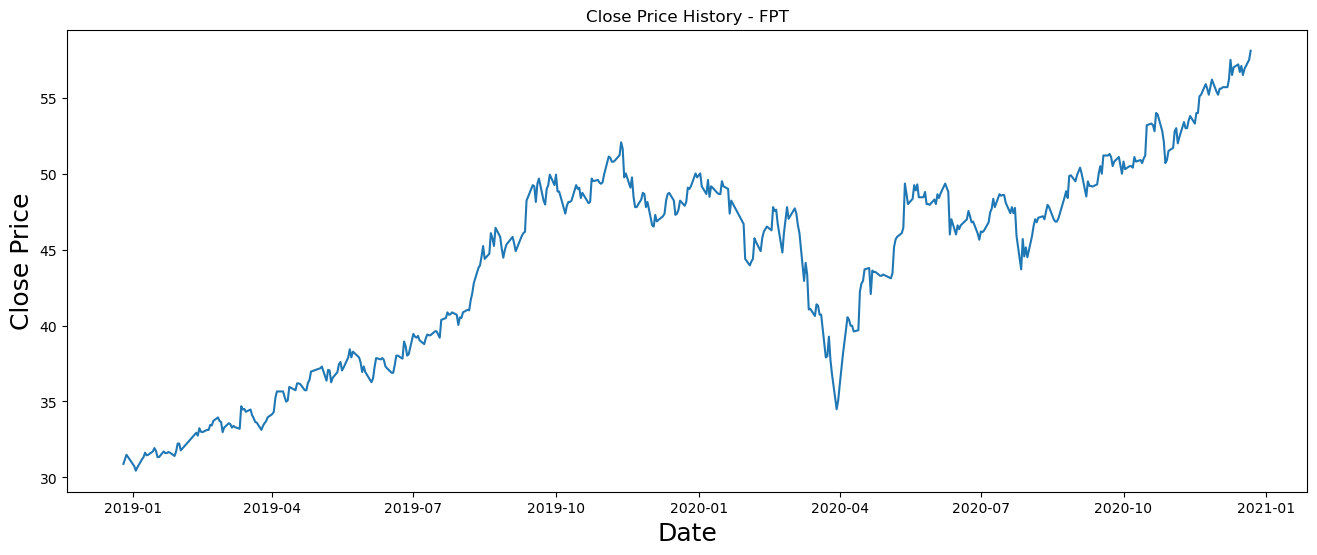

In [6]:
# Hiển thị biểu đồ giá đóng cửa của cổ phiếu FPT
plt.figure(figsize=(16, 6))
plt.title('Close Price History - FPT')
plt.plot(fpt['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()

In [7]:
# Tính biến động giá cổ phiếu
N = 1 # Đổi thành số phút, giờ hoặc ngày mà bạn muốn tính biến động
fpt['Close Future'] = fpt['Close'].shift(-N)
fpt['Price Change'] = fpt['Close Future'] - fpt['Close']

# Loại bỏ dòng có giá trị NaN
fpt.dropna(inplace=True)

In [8]:
fpt.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Close Future,Price Change
Date,,,,,,,,,,
2018-12-26,FPT,2018-12-26 14:46:00,30.89,30.89,30.89,30.89,23190,0,31.19,0.30
2018-12-27,FPT,2018-12-27 14:46:00,31.19,31.19,31.19,31.19,38230,0,31.49,0.30
2018-12-28,FPT,2018-12-28 14:46:00,31.49,31.49,31.49,31.49,156050,0,30.74,-0.75
2019-01-02,FPT,2019-01-02 14:46:00,30.74,30.74,30.74,30.74,64860,0,30.44,-0.30
2019-01-03,FPT,2019-01-03 14:46:00,30.44,30.44,30.44,30.44,27490,0,30.66,0.22


In [9]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(fpt['Price Change'].values.reshape(-1, 1))

In [10]:
# Tạo training set và test set
training_data_len = int(np.ceil(len(scaled_data) * .95))
train_data = scaled_data[0:training_data_len, :]

In [11]:
# Tạo dữ liệu huấn luyện
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [13]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Huấn luyện mô hình
model.fit(x_train, y_train, batch_size=1, epochs=1)



410/410 [==============================] - 12s 17ms/step - loss: 0.0217


In [15]:
# Dự đoán trên tập test
test_data = scaled_data[training_data_len - 60:, :]
x_test, y_test = [], fpt['Price Change'].values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

1/1 [==============================] - 1s 1s/step


In [16]:
# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.6154622364791459


FPT Stock Price Prediction

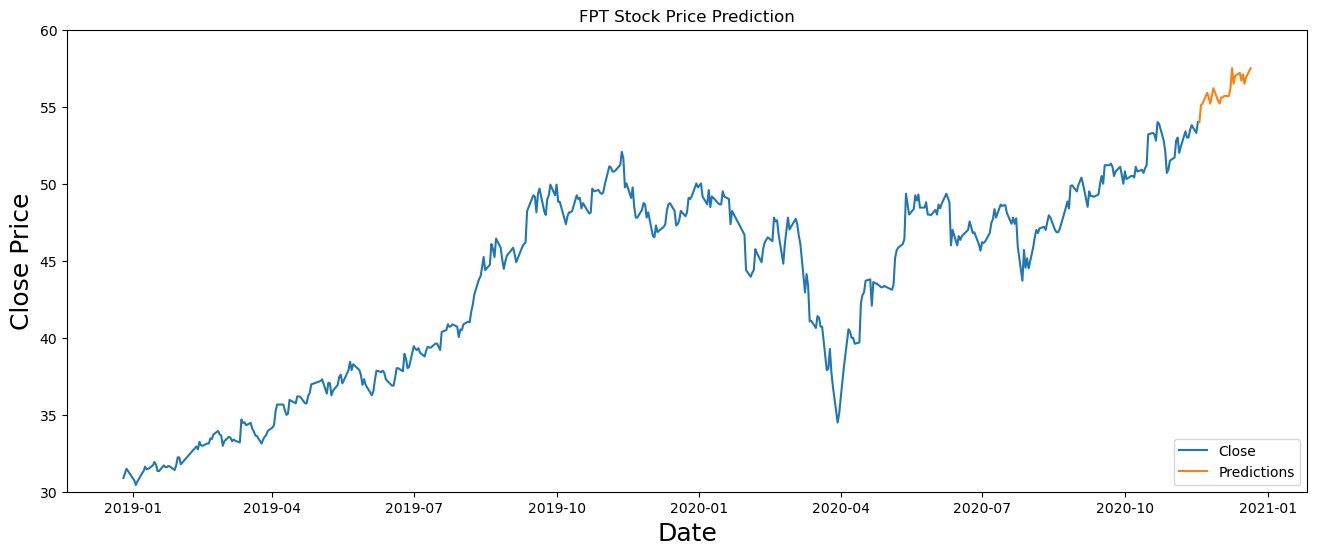

In [17]:
# Vẽ biểu đồ
train = fpt[:training_data_len]
valid = fpt[training_data_len:].copy()
valid['Predictions'] = predictions
plt.figure(figsize=(16, 6))
plt.title('FPT Stock Price Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.ylim(30, 60)
plt.legend(['Close','Predictions'], loc='lower right')

plt.show()


FPT STOCK PRICE CHANGE

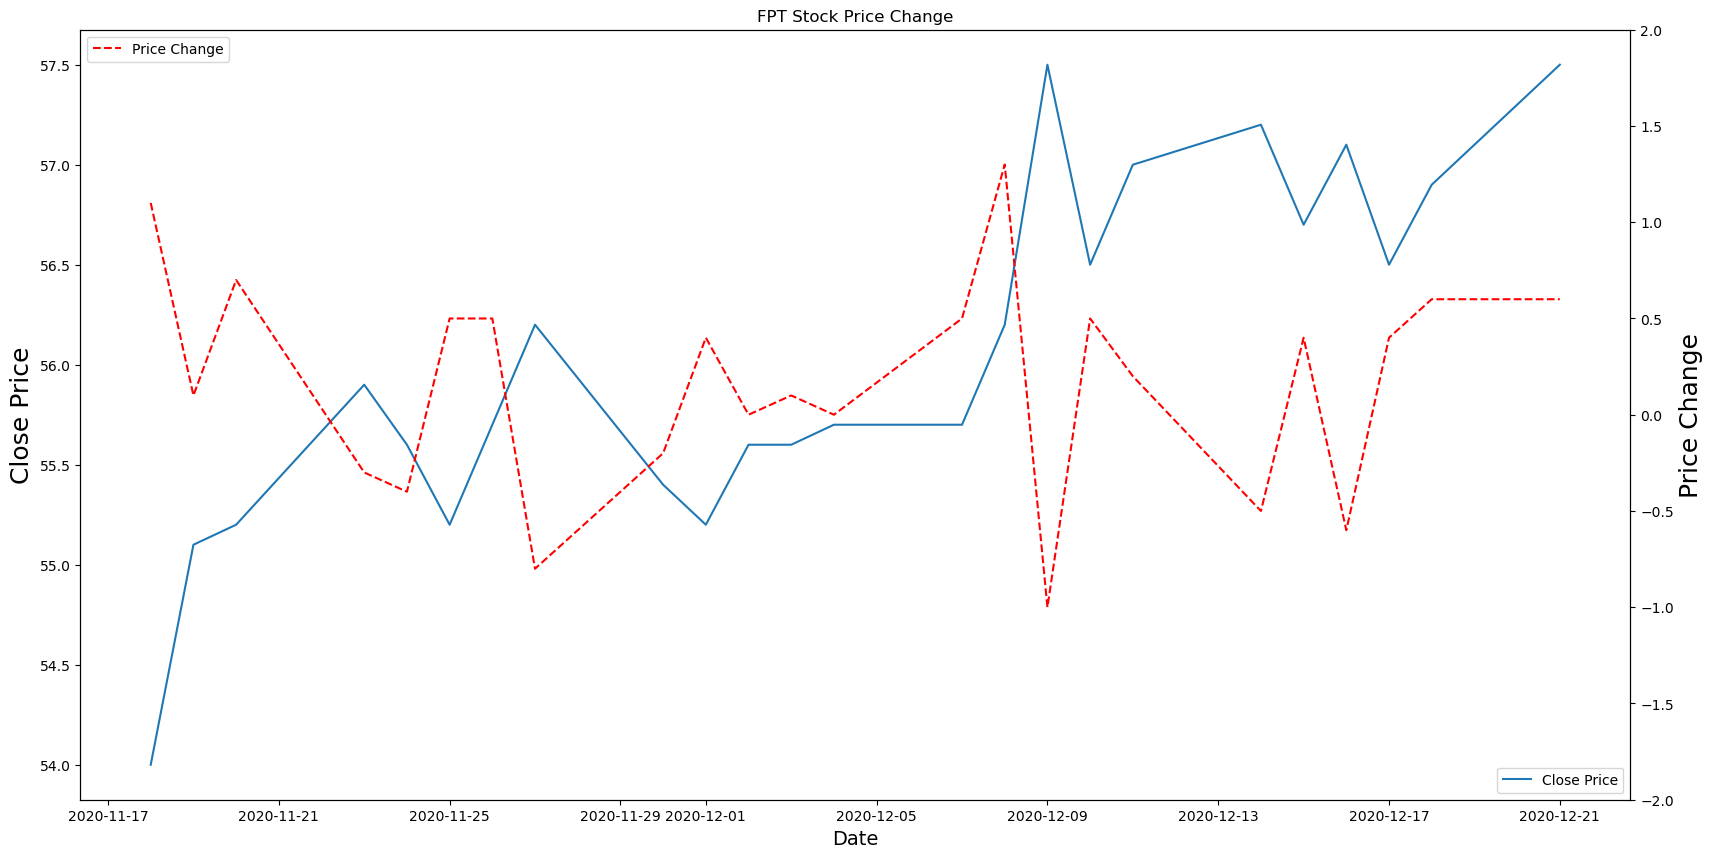

In [18]:
plt.figure(figsize=(20,10))
plt.title('FPT Stock Price Change')
plt.xlabel('Date', fontsize=14)
plt.plot(valid['Close'],  label='Close Price')
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='lower right')
plt.twinx()
plt.plot(valid.index, valid['Price Change'], color='red', linestyle='dashed',  label='Price Change')
plt.ylabel('Price Change', fontsize=18)
plt.ylim(-2, 2) 
plt.legend(loc='upper left')
plt.show()

In [19]:
valid

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Close Future,Price Change,Predictions
Date,,,,,,,,,,,
2020-11-18,FPT,2020-11-18 14:46:00,54.0,54.0,54.0,54.0,95730,0,55.1,1.1,-0.072642
2020-11-19,FPT,2020-11-19 14:46:00,55.1,55.1,55.1,55.1,507280,0,55.2,0.1,-0.053870
2020-11-20,FPT,2020-11-20 14:46:00,55.2,55.2,55.2,55.2,71540,0,55.9,0.7,-0.043946
2020-11-23,FPT,2020-11-23 14:46:00,55.9,55.9,55.9,55.9,124390,0,55.6,-0.3,-0.029964
2020-11-24,FPT,2020-11-24 14:46:00,55.6,55.6,55.6,55.6,54190,0,55.2,-0.4,-0.032443
2020-11-25,FPT,2020-11-25 14:46:00,55.2,55.2,55.2,55.2,137380,0,55.7,0.5,-0.047619
2020-11-26,FPT,2020-11-26 14:46:00,55.7,55.7,55.7,55.7,103870,0,56.2,0.5,-0.051857
2020-11-27,FPT,2020-11-27 14:46:00,56.2,56.2,56.2,56.2,128490,0,55.4,-0.8,-0.048243
2020-11-30,FPT,2020-11-30 14:46:00,55.4,55.4,55.4,55.4,437300,0,55.2,-0.2,-0.065360


2. MSN

In [20]:
msn.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
Date,,,,,,,,
2017-12-25,MSN,2017-12-25 14:46:00,74.2,74.2,74.2,74.2,18220,0
2017-12-26,MSN,2017-12-26 14:46:00,75.5,75.5,75.5,75.5,56650,0
2017-12-27,MSN,2017-12-27 14:46:00,75.0,75.0,75.0,75.0,46380,0
2017-12-28,MSN,2017-12-28 14:46:00,75.7,75.7,75.7,75.7,59450,0
2017-12-29,MSN,2017-12-29 14:46:00,76.7,76.7,76.7,76.7,17490,0


CLOSING PRICE OF MSN

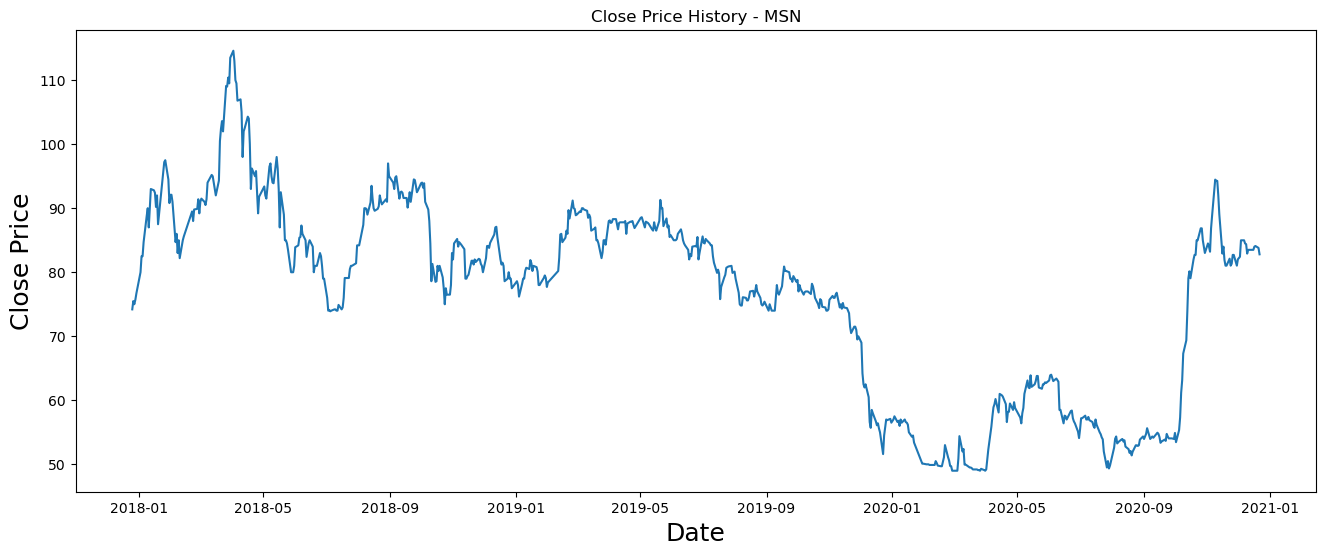

In [21]:
# Hiển thị biểu đồ giá đóng cửa của cổ phiếu msn
plt.figure(figsize=(16, 6))
plt.title('Close Price History - MSN')
plt.plot(msn['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()

In [22]:
# Tính biến động giá cổ phiếu
N = 1 # Đổi thành số phút, giờ hoặc ngày mà bạn muốn tính biến động
msn['Close Future'] = msn['Close'].shift(-N)
msn['Price Change'] = msn['Close Future'] - msn['Close']

# Loại bỏ dòng có giá trị NaN
msn.dropna(inplace=True)

In [23]:
msn.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Close Future,Price Change
Date,,,,,,,,,,
2017-12-25,MSN,2017-12-25 14:46:00,74.2,74.2,74.2,74.2,18220,0,75.5,1.3
2017-12-26,MSN,2017-12-26 14:46:00,75.5,75.5,75.5,75.5,56650,0,75.0,-0.5
2017-12-27,MSN,2017-12-27 14:46:00,75.0,75.0,75.0,75.0,46380,0,75.7,0.7
2017-12-28,MSN,2017-12-28 14:46:00,75.7,75.7,75.7,75.7,59450,0,76.7,1.0
2017-12-29,MSN,2017-12-29 14:46:00,76.7,76.7,76.7,76.7,17490,0,80.0,3.3


In [24]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(msn['Price Change'].values.reshape(-1, 1))

In [25]:
# Tạo training set và test set
training_data_len = int(np.ceil(len(scaled_data) * .95))
train_data = scaled_data[0:training_data_len, :]

In [26]:
# Tạo dữ liệu huấn luyện
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [27]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [28]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
# Huấn luyện mô hình
model.fit(x_train, y_train, batch_size=1, epochs=1)

644/644 [==============================] - 15s 16ms/step - loss: 0.0108


In [30]:
# Dự đoán trên tập test
test_data = scaled_data[training_data_len - 60:, :]
x_test, y_test = [], msn['Price Change'].values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 1s 10ms/step


In [31]:
# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 1.8953554670796113


MSN STOCK PRICE PREDICTION

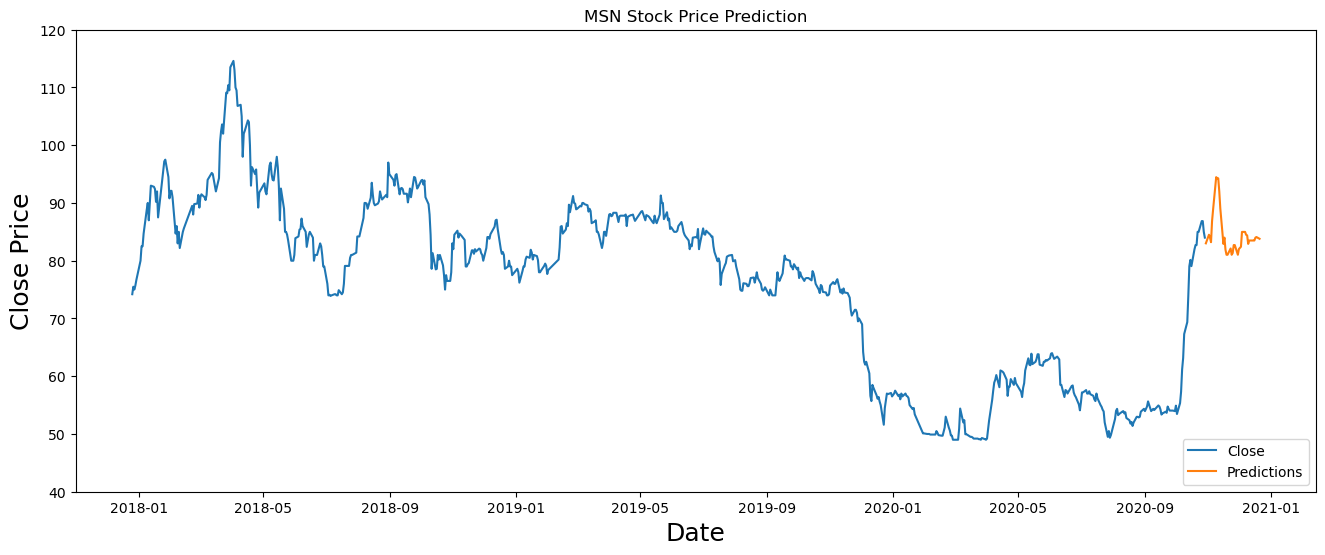

In [32]:
# Vẽ biểu đồ
train = msn[:training_data_len]
valid = msn[training_data_len:].copy()
valid['Predictions'] = predictions
plt.figure(figsize=(16, 6))
plt.title('MSN Stock Price Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.ylim(40,120)
plt.legend(['Close','Predictions'], loc='lower right')

plt.show()


MSN STOCK PRICE CHANGE

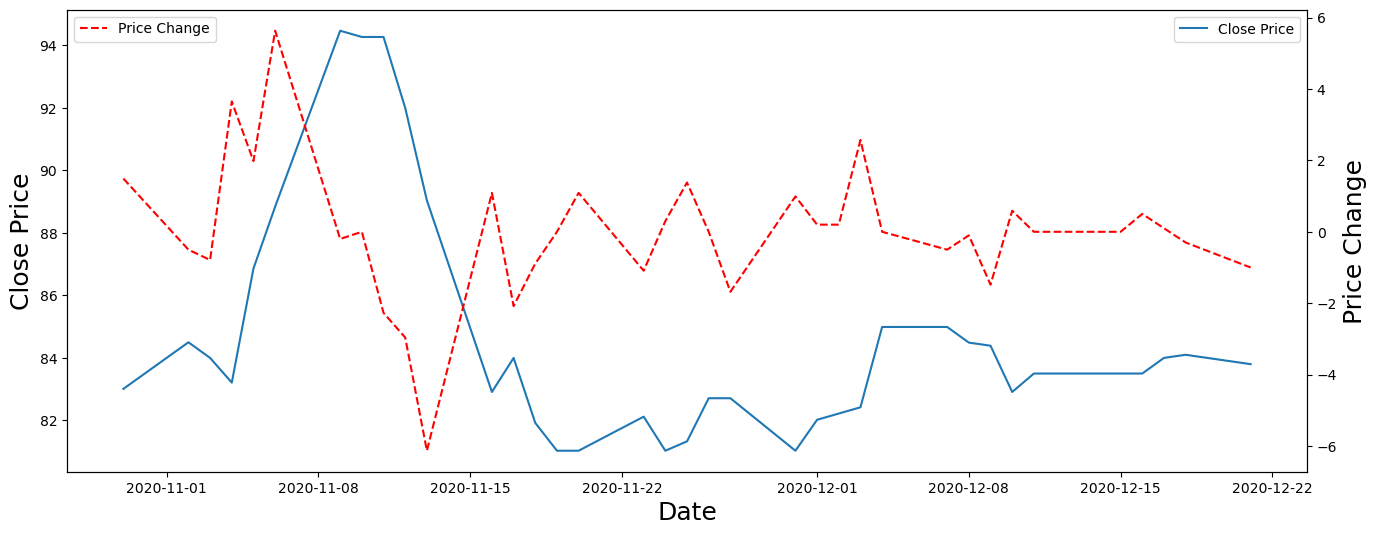

In [33]:
plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=18)
plt.plot(valid['Close'],  label='Close Price')
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.twinx()
plt.plot(valid.index, valid['Price Change'], color='red', linestyle='dashed',  label='Price Change')
plt.ylabel('Price Change', fontsize=18)
plt.legend(loc='upper left')
plt.show()

In [34]:
valid

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Close Future,Price Change,Predictions
Date,,,,,,,,,,,
2020-10-30,MSN,2020-10-30 14:46:00,83.01,83.01,83.01,83.01,1845930,0,84.50,1.49,-0.063920
2020-11-02,MSN,2020-11-02 14:46:00,84.50,84.50,84.50,84.50,1953660,0,84.00,-0.50,-0.066032
2020-11-03,MSN,2020-11-03 14:46:00,84.00,84.00,84.00,84.00,814360,0,83.21,-0.79,-0.083024
2020-11-04,MSN,2020-11-04 14:46:00,83.21,83.21,83.21,83.21,447440,0,86.86,3.65,-0.114235
2020-11-05,MSN,2020-11-05 14:46:00,86.86,86.86,86.86,86.86,420810,0,88.84,1.98,-0.020714
2020-11-06,MSN,2020-11-06 14:46:00,88.84,88.84,88.84,88.84,521220,0,94.47,5.63,0.074583
2020-11-09,MSN,2020-11-09 14:46:00,94.47,94.47,94.47,94.47,1078090,0,94.27,-0.20,0.263567
2020-11-10,MSN,2020-11-10 14:46:00,94.27,94.27,94.27,94.27,430320,0,94.27,0.00,0.311691
2020-11-11,MSN,2020-11-11 14:46:00,94.27,94.27,94.27,94.27,427590,0,92.00,-2.27,0.292529


3. PNJ

In [35]:
pnj.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
Date,,,,,,,,
2018-03-01,PNJ,2018-03-01 14:46:00,77.66,77.66,77.66,77.66,2822,0
2018-03-02,PNJ,2018-03-02 14:46:00,77.33,77.33,77.33,77.33,1421,0
2018-03-05,PNJ,2018-03-05 14:46:00,78.28,78.28,78.28,78.28,1224,0
2018-03-06,PNJ,2018-03-06 14:46:00,81.45,81.45,81.45,81.45,2540,0
2018-03-07,PNJ,2018-03-07 14:46:00,80.74,80.74,80.74,80.74,439,0


CLOSING PRICE OF PNJ

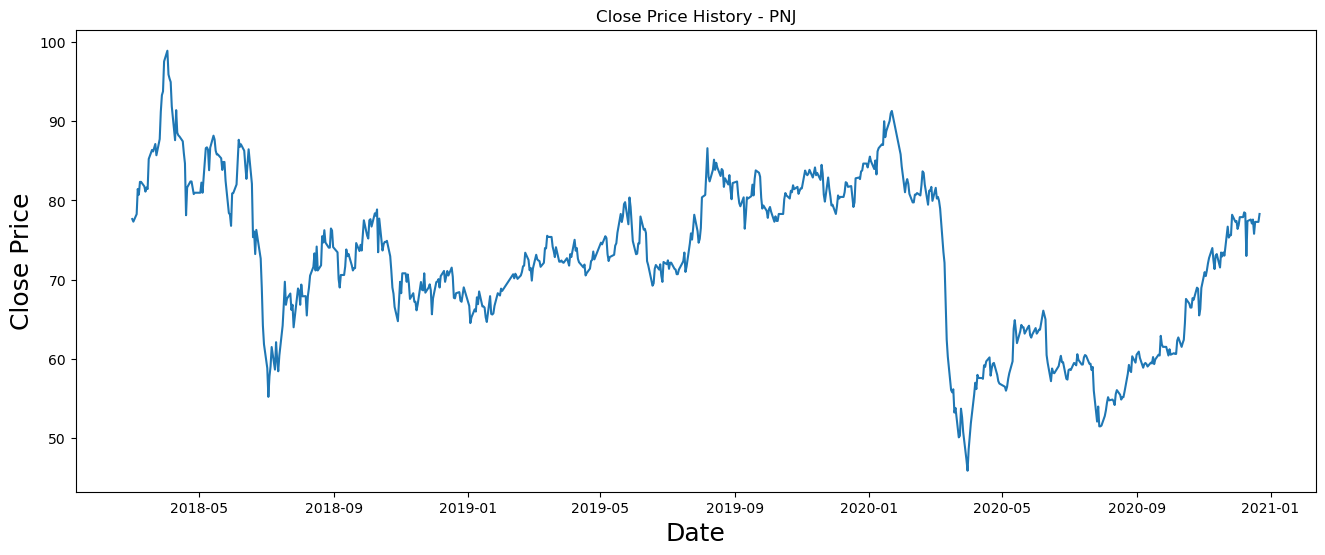

In [36]:
plt.figure(figsize=(16, 6))
plt.title('Close Price History - PNJ')
plt.plot(pnj['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()

In [37]:
# Tính biến động giá cổ phiếu
N = 1 # Đổi thành số phút, giờ hoặc ngày mà bạn muốn tính biến động
pnj['Close Future'] = pnj['Close'].shift(-N)
pnj['Price Change'] = pnj['Close Future'] - pnj['Close']

# Loại bỏ dòng có giá trị NaN
pnj.dropna(inplace=True)

In [38]:
pnj.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Close Future,Price Change
Date,,,,,,,,,,
2018-03-01,PNJ,2018-03-01 14:46:00,77.66,77.66,77.66,77.66,2822,0,77.33,-0.33
2018-03-02,PNJ,2018-03-02 14:46:00,77.33,77.33,77.33,77.33,1421,0,78.28,0.95
2018-03-05,PNJ,2018-03-05 14:46:00,78.28,78.28,78.28,78.28,1224,0,81.45,3.17
2018-03-06,PNJ,2018-03-06 14:46:00,81.45,81.45,81.45,81.45,2540,0,80.74,-0.71
2018-03-07,PNJ,2018-03-07 14:46:00,80.74,80.74,80.74,80.74,439,0,82.35,1.61


In [39]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(pnj['Price Change'].values.reshape(-1, 1))

In [40]:
# Tạo training set và test set
training_data_len = int(np.ceil(len(scaled_data) * .95))
train_data = scaled_data[0:training_data_len, :]

In [41]:
# Tạo dữ liệu huấn luyện
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [42]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [43]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [44]:
# Huấn luyện mô hình
model.fit(x_train, y_train, batch_size=1, epochs=1)

608/608 [==============================] - 15s 16ms/step - loss: 0.0210


In [45]:
# Dự đoán trên tập test
test_data = scaled_data[training_data_len - 60:, :]
x_test, y_test = [], pnj['Price Change'].values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 1s 9ms/step


In [46]:
# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 1.678304736004181


PNJ STOCK PRICE PREDICTION

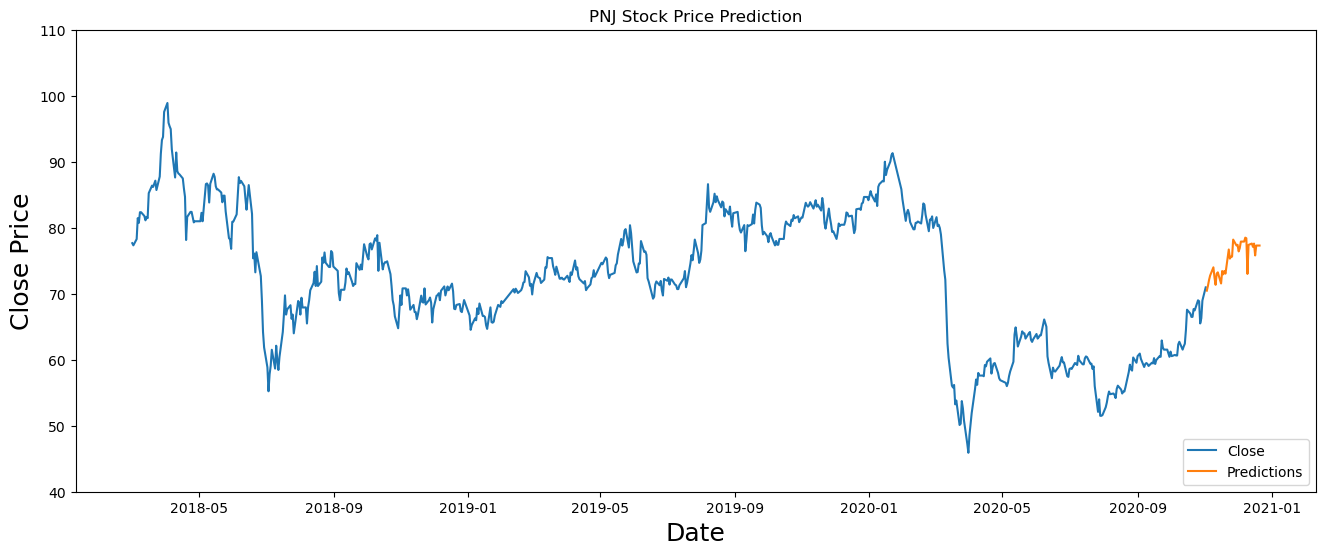

In [47]:
# Vẽ biểu đồ
train = pnj[:training_data_len]
valid = pnj[training_data_len:].copy()
valid['Predictions'] = predictions
plt.figure(figsize=(16, 6))
plt.title('PNJ Stock Price Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.ylim(40,110)
plt.legend(['Close','Predictions'], loc='lower right')

plt.show()


PNJ STOCK PRICE CHANGE

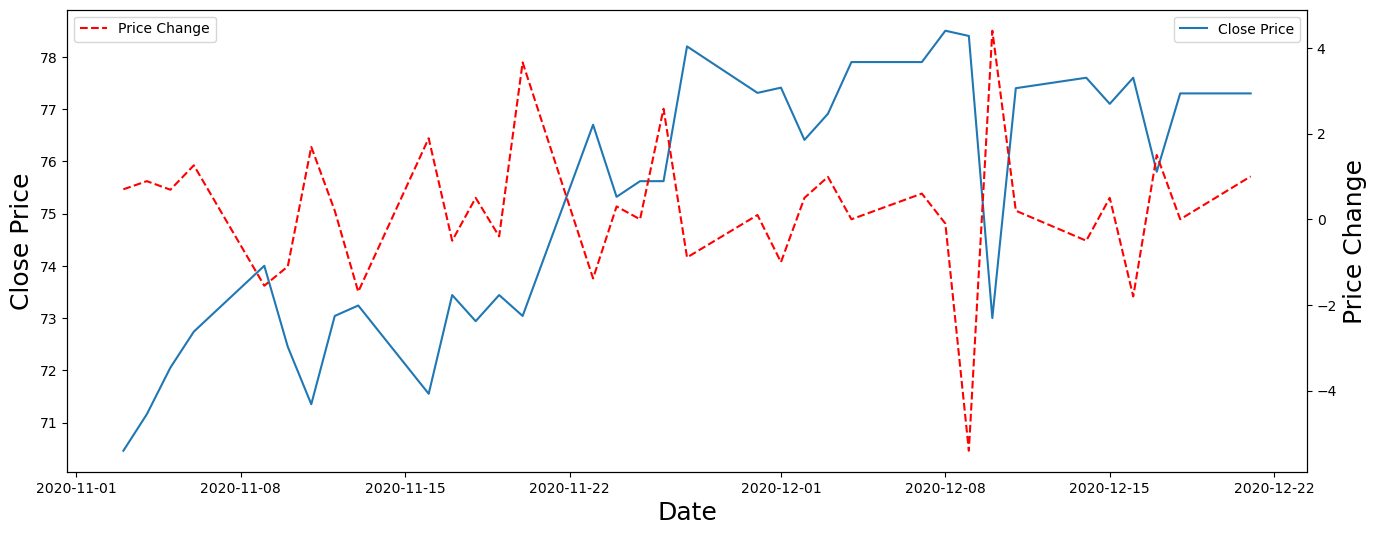

In [48]:
plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=18)
plt.plot(valid['Close'],  label='Close Price')
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.twinx()
plt.plot(valid.index, valid['Price Change'], color='red', linestyle='dashed',  label='Price Change')
plt.ylabel('Price Change', fontsize=18)
plt.legend(loc='upper left')
plt.show()

In [49]:
valid

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Close Future,Price Change,Predictions
Date,,,,,,,,,,,
2020-11-03,PNJ,2020-11-03 14:46:00,70.46,70.46,70.46,70.46,56510,0,71.16,0.70,0.279628
2020-11-04,PNJ,2020-11-04 14:46:00,71.16,71.16,71.16,71.16,34240,0,72.05,0.89,0.292623
2020-11-05,PNJ,2020-11-05 14:46:00,72.05,72.05,72.05,72.05,51860,0,72.74,0.69,0.308799
2020-11-06,PNJ,2020-11-06 14:46:00,72.74,72.74,72.74,72.74,56020,0,74.00,1.26,0.320147
2020-11-09,PNJ,2020-11-09 14:46:00,74.00,74.00,74.00,74.00,43870,0,72.45,-1.55,0.342776
2020-11-10,PNJ,2020-11-10 14:46:00,72.45,72.45,72.45,72.45,46840,0,71.35,-1.10,0.296204
2020-11-11,PNJ,2020-11-11 14:46:00,71.35,71.35,71.35,71.35,75120,0,73.04,1.69,0.227191
2020-11-12,PNJ,2020-11-12 14:46:00,73.04,73.04,73.04,73.04,42820,0,73.24,0.20,0.226660
2020-11-13,PNJ,2020-11-13 14:46:00,73.24,73.24,73.24,73.24,38420,0,71.55,-1.69,0.224655


4. vic

In [50]:
vic.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
Date,,,,,,,,
2018-10-17,VIC,2018-10-17 14:46:00,99.0,99.0,99.0,99.0,203400,0
2018-10-18,VIC,2018-10-18 14:46:00,99.1,99.1,99.1,99.1,88050,0
2018-10-19,VIC,2018-10-19 14:46:00,99.1,99.1,99.1,99.1,535710,0
2018-10-22,VIC,2018-10-22 14:46:00,99.1,99.1,99.1,99.1,64640,0
2018-10-23,VIC,2018-10-23 14:46:00,99.0,99.0,99.0,99.0,66050,0


CLOSING PRICE OF VIC

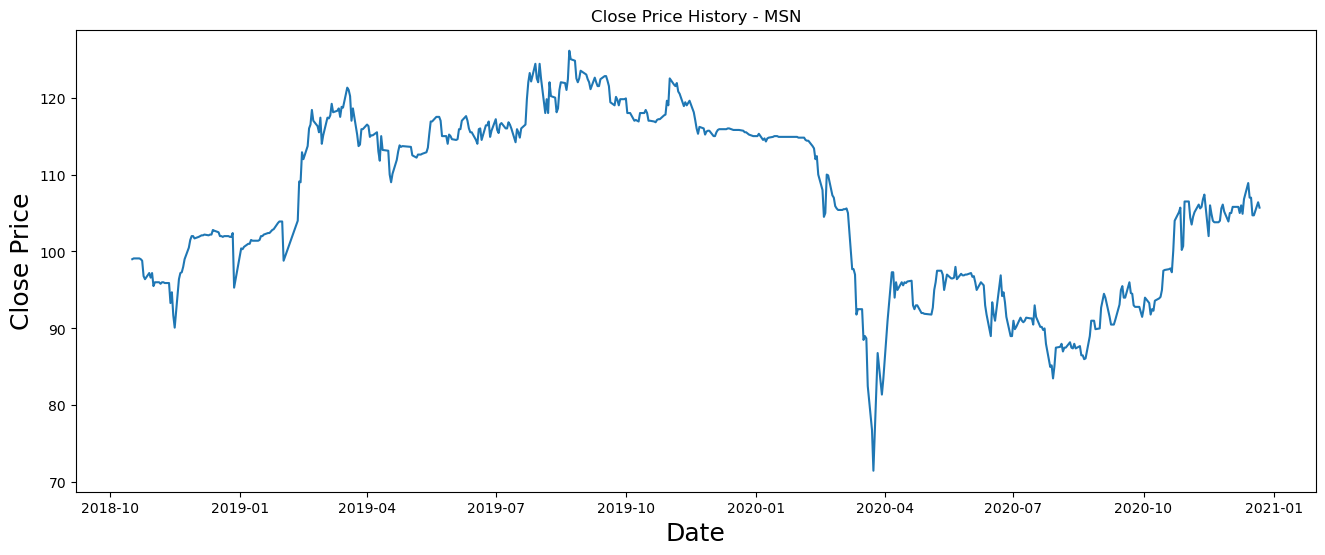

In [51]:
plt.figure(figsize=(16, 6))
plt.title('Close Price History - MSN')
plt.plot(vic['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()

In [52]:
# Tính biến động giá cổ phiếu
N = 1 # Đổi thành số phút, giờ hoặc ngày mà bạn muốn tính biến động
vic['Close Future'] = vic['Close'].shift(-N)
vic['Price Change'] = vic['Close Future'] - vic['Close']

# Loại bỏ dòng có giá trị NaN
vic.dropna(inplace=True)

In [53]:
vic.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Close Future,Price Change
Date,,,,,,,,,,
2018-10-17,VIC,2018-10-17 14:46:00,99.0,99.0,99.0,99.0,203400,0,99.1,0.1
2018-10-18,VIC,2018-10-18 14:46:00,99.1,99.1,99.1,99.1,88050,0,99.1,0.0
2018-10-19,VIC,2018-10-19 14:46:00,99.1,99.1,99.1,99.1,535710,0,99.1,0.0
2018-10-22,VIC,2018-10-22 14:46:00,99.1,99.1,99.1,99.1,64640,0,99.0,-0.1
2018-10-23,VIC,2018-10-23 14:46:00,99.0,99.0,99.0,99.0,66050,0,98.8,-0.2


In [54]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(vic['Price Change'].values.reshape(-1, 1))

In [55]:
# Tạo training set và test set
training_data_len = int(np.ceil(len(scaled_data) * .95))
train_data = scaled_data[0:training_data_len, :]

In [56]:
# Tạo dữ liệu huấn luyện
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [57]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [58]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [59]:
# Huấn luyện mô hình
model.fit(x_train, y_train, batch_size=1, epochs=1)

456/456 [==============================] - 13s 16ms/step - loss: 0.0197


In [60]:
# Dự đoán trên tập test
test_data = scaled_data[training_data_len - 60:, :]
x_test, y_test = [], vic['Price Change'].values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

1/1 [==============================] - 1s 1s/step


In [61]:
# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 2.591554941814714


VIC STOCK PRICE PREDICTION

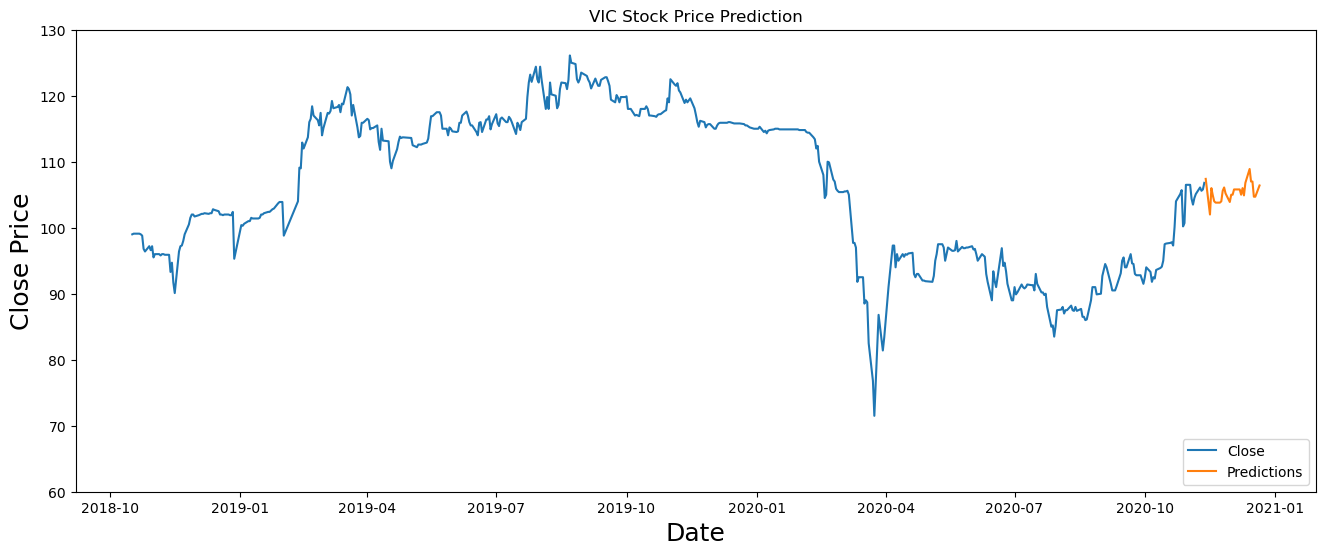

In [62]:
# Vẽ biểu đồ
train = vic[:training_data_len]
valid = vic[training_data_len:].copy()
valid['Predictions'] = predictions
plt.figure(figsize=(16, 6))
plt.title('VIC Stock Price Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.ylim(60,130)
plt.legend(['Close','Predictions'], loc='lower right')

plt.show()


VIC STOCK PRICE CHANGE

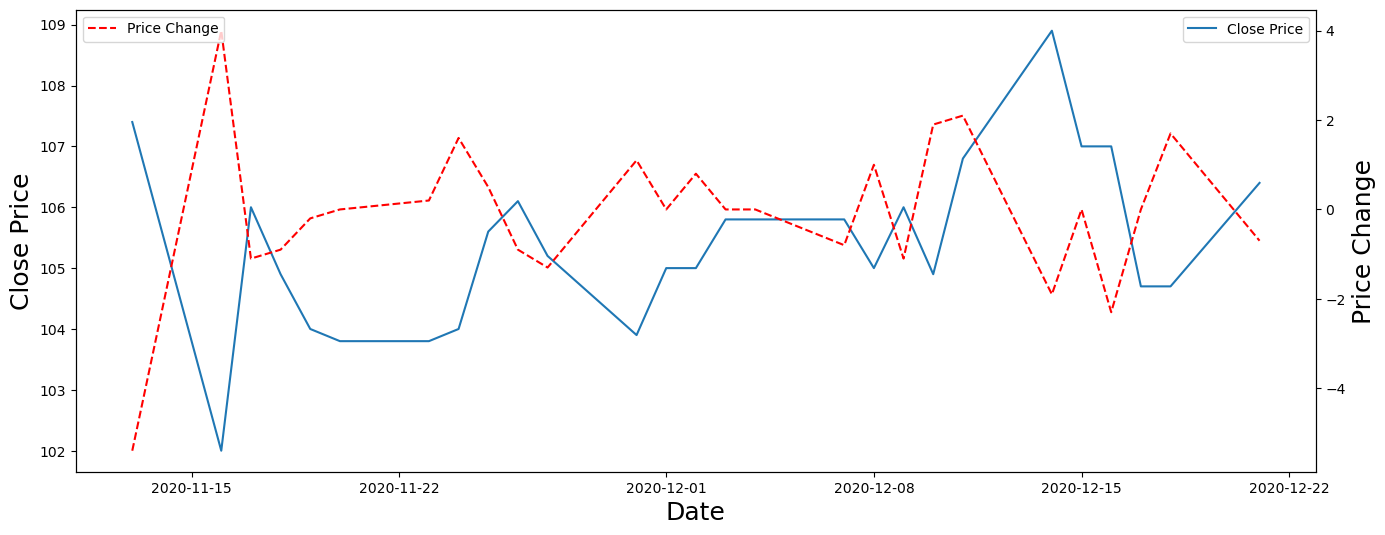

In [63]:
plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=18)
plt.plot(valid['Close'],  label='Close Price')
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.twinx()
plt.plot(valid.index, valid['Price Change'], color='red', linestyle='dashed',  label='Price Change')
plt.ylabel('Price Change', fontsize=18)
plt.legend(loc='upper left')
plt.show()

In [64]:
valid

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Close Future,Price Change,Predictions
Date,,,,,,,,,,,
2020-11-13,VIC,2020-11-13 14:46:00,107.4,107.4,107.4,107.4,64290,0,102.0,-5.4,2.003352
2020-11-16,VIC,2020-11-16 14:46:00,102.0,102.0,102.0,102.0,256790,0,106.0,4.0,1.883438
2020-11-17,VIC,2020-11-17 14:46:00,106.0,106.0,106.0,106.0,54880,0,104.9,-1.1,1.886291
2020-11-18,VIC,2020-11-18 14:46:00,104.9,104.9,104.9,104.9,64510,0,104.0,-0.9,1.869008
2020-11-19,VIC,2020-11-19 14:46:00,104.0,104.0,104.0,104.0,392850,0,103.8,-0.2,1.835805
2020-11-20,VIC,2020-11-20 14:46:00,103.8,103.8,103.8,103.8,29070,0,103.8,0.0,1.810380
2020-11-23,VIC,2020-11-23 14:46:00,103.8,103.8,103.8,103.8,55350,0,104.0,0.2,1.796778
2020-11-24,VIC,2020-11-24 14:46:00,104.0,104.0,104.0,104.0,32360,0,105.6,1.6,1.796034
2020-11-25,VIC,2020-11-25 14:46:00,105.6,105.6,105.6,105.6,38750,0,106.1,0.5,1.834442
